## Feature Selection using Random Forest
###### Step 1: Data Normalization
###### Step 2: Shuffled model (permutation tests) for 100 times, with random labels
###### Step 3: 10-fold validation for 100 DT models (generating 100*10 shuffled variable importances)
###### Step 4: calculate mean values of variable importances (generating 10 mean shuffled variable importances, each feature 10 shuffled importances)
###### Step 5: 10-fold validation for the real model (generating 10 real variable importances, each feature 10 real importances)
###### Step 6: Significance testing for shuffled and real importances (Wilcoxon signed-rank test)

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

# PRS dataset
dataset = pd.read_pickle('datafile/PRS_dataset.pkl')
dataset = dataset.fillna(0)
print(dataset.shape)
dataset.head()

(301508, 413)


,Is_anxiety,446,447,448,449,450,451,452,453,454,...,848,849,850,851,852,853,854,855,856,857
1000023,0,0.000507,0.002420,-0.000185,-0.000145,-0.000371,-0.000873,0.012805,0.000115,0.000151,...,0.025738,-0.001572,0.014031,-0.000354,-5.377204e-07,0.000654,-0.002815,-0.000183,0.014240,-0.003520
1000030,1,0.000276,0.001576,0.000038,-0.000381,-0.000399,-0.004763,0.014032,0.000109,0.000093,...,0.014733,-0.000623,0.005552,-0.000244,3.097558e-04,-0.000190,0.000197,-0.000050,0.012340,-0.005790
1000041,0,0.000649,-0.000098,-0.000086,0.000090,-0.000678,-0.004804,0.007270,-0.000024,0.000109,...,0.011649,-0.000921,0.010997,-0.000557,1.148748e-04,-0.000354,-0.011370,-0.000419,0.006975,-0.004178
1000059,0,0.000585,0.000814,-0.000066,-0.000621,0.000105,0.001870,0.002563,0.000106,0.000097,...,0.022186,-0.000923,0.015620,-0.000159,2.290053e-04,-0.000769,0.006247,-0.000164,0.001851,-0.001964
1000062,0,0.000214,0.001490,0.000117,-0.000153,-0.000603,-0.005913,0.012513,0.000089,0.000109,...,0.022118,-0.000425,0.007184,0.000349,2.946820e-04,0.001721,0.011161,-0.000200,0.010253,-0.006825


In [2]:
# step 1
def normalization(data):
    _range = np.max(np.max(abs(data)))
    return data / _range

nor_feature = dataset.drop(['Is_anxiety'], axis=1)
nor_feature = normalization(nor_feature)
nor_feature.head()

c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


,446,447,448,449,450,451,452,453,454,455,...,848,849,850,851,852,853,854,855,856,857
1000023,0.001523,0.007263,-0.000556,-0.000436,-0.001114,-0.002620,0.038436,0.000345,0.000453,0.003520,...,0.077259,-0.004720,0.042117,-0.001063,-0.000002,0.001963,-0.008451,-0.000549,0.042746,-0.010566
1000030,0.000827,0.004731,0.000113,-0.001145,-0.001198,-0.014296,0.042122,0.000327,0.000279,0.002764,...,0.044224,-0.001871,0.016666,-0.000733,0.000930,-0.000570,0.000592,-0.000150,0.037043,-0.017380
1000041,0.001950,-0.000294,-0.000258,0.000271,-0.002035,-0.014419,0.021824,-0.000073,0.000327,-0.010717,...,0.034966,-0.002765,0.033012,-0.001673,0.000345,-0.001062,-0.034130,-0.001257,0.020937,-0.012541
1000059,0.001757,0.002443,-0.000198,-0.001865,0.000316,0.005612,0.007694,0.000318,0.000291,0.028159,...,0.066598,-0.002770,0.046888,-0.000478,0.000687,-0.002308,0.018753,-0.000494,0.005557,-0.005895
1000062,0.000643,0.004472,0.000351,-0.000460,-0.001809,-0.017750,0.037560,0.000266,0.000327,-0.020703,...,0.066394,-0.001275,0.021566,0.001049,0.000885,0.005165,0.033502,-0.000599,0.030776,-0.020487


In [6]:
# shuffle function
import numpy as np
def shuffle_f(a):
    a = a.T
    np.random.shuffle(a)
    np.random.shuffle(a)
    a = a.T
    np.random.shuffle(a)
    np.random.shuffle(a)
    return a

0.9065
max score：0.9065 subtree num：31


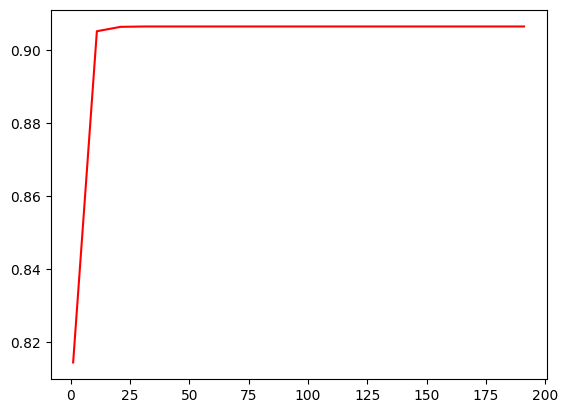

In [4]:
# hyper-parameter tuning
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

X = nor_feature.values[0:10000]
Y = dataset['Is_anxiety'].values[0:10000]
rfc = RandomForestClassifier(n_estimators=100, random_state=90)
score_pre = cross_val_score(rfc, X, Y, cv=5).mean()
print(score_pre)

score_lt = []
for i in range(0,200,10):
    rfc = RandomForestClassifier(n_estimators=i+1
                                ,random_state=90)
    score = cross_val_score(rfc, X, Y, cv=5).mean()
    score_lt.append(score)
score_max = max(score_lt)
print('max score：{}'.format(score_max),
      'subtree num：{}'.format(score_lt.index(score_max)*10+1))


x = np.arange(1,201,10)
plt.subplot(111)
plt.plot(x, score_lt, 'r-')
plt.show() 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
from sklearn.model_selection import cross_val_score, KFold
# Step 2: Shuffled model (permutation tests) for 100 times, with random labels
# Step 3: 10-fold validation for 100 DT models (generating 100*10 shuffled variable importances)
Y = dataset['Is_anxiety'].values
for i in tqdm(range(100)): # shuffle 100 times
    X = shuffle_f(nor_feature.values)
    # 10-fold
    cv_result = []
    cv = KFold(n_splits=10)
    for train_index, valid_index in cv.split(X):
        train_x,test_x = X[train_index], X[valid_index]
        train_y,test_y = Y[train_index], Y[valid_index]
        clf = RandomForestClassifier(n_estimators=50,random_state=90)
        clf.fit(train_x, train_y)
        feat_importance = clf.feature_importances_
        cv_result.append(feat_importance)
    importance = np.array(cv_result)
    print(importance.shape) # expected 10 * 412
    np.save('RF_importance_array/' + str(i) + '.npy', importance)

In [ ]:
# Step 4: calculate mean values of variable importances (generating 10 mean shuffled variable importances, each feature 10 shuffled importances)
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
from sklearn.model_selection import cross_val_score, KFold
import numpy as np
sum_array = np.zeros(shape=(10,412))
for i in range(100):
    RF_importance_array = np.load('RF_importance_array/' + str(i) + '.npy')
    # print(DT_importance_array.shape) # (10, 412)
    for j in range(10):
        for k in range(412):
            sum_array[j][k] += RF_importance_array[j][k]
svg_array = sum_array/100
print(svg_array.shape)

In [ ]:
# Step 5: 10-fold validation for the real model (generating 10 real variable importances, each feature 10 real importances)
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
from sklearn.model_selection import cross_val_score, KFold
X = nor_feature.values
Y = dataset['Is_anxiety'].values
cv_result = []
cv = KFold(n_splits=10)
for train_index, valid_index in cv.split(X):
    train_x,test_x = X[train_index],X[valid_index]
    train_y,test_y = Y[train_index], Y[valid_index]
    clf = RandomForestClassifier(n_estimators=50,random_state=90)
    clf.fit(train_x, train_y)
    feat_importance = clf.feature_importances_
    cv_result.append(feat_importance)
importance = np.array(cv_result)
print(importance.shape) # expected 10 * 412
np.save('RF_importance_array/real-10fold.npy', importance)